# RAG
## Retrieval Augmented Generation

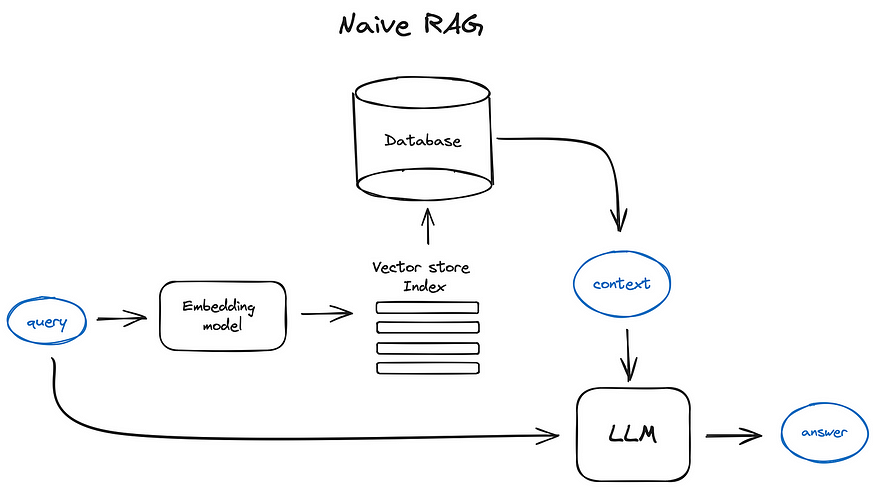

Combine a LLM model with a information's retrieval system. The model access external data sources to generate better answers.

In a nutshell, it optimizes Ai's answer giving it another reference other than its training base.

Vectorizinfg documents (Embeddings) to capture its semantic value allows the system to recognize more related information.

There are few RAG strategies, for example the Naive RAG.

### *Naive RAG*

The vectorization model used to train is the same used to in the prompt.
After that a certain number of relevant chunks are selected by vector simillarity, then these chunks are used to enhance the answer.

## Using RAG to review code



In [ ]:
pip uninstall -y langchain langchain-community langchain-openai langchain-core langchain-chroma


In [ ]:
pip install langchain==0.2.7 langchain-community==0.2.6 langchain-openai==0.1.8 langchain-chroma==0.1.2


###Important imports to be used

In [ ]:
from langchain_community.document_loaders.generic import GenericLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.document_loaders.parsers.language import LanguageParser
from langchain_text_splitters import Language

import os
from git import Repo

Defining where the repo is going to be cloned and cloning it

In [ ]:
repo_path = './test_repo'

In [ ]:
repo = Repo.clone_from('https://github.com/langchain-ai/langchain' , to_path=repo_path)

Loading the code as documents

In [ ]:
loader = GenericLoader.from_filesystem(
    repo_path + "/libs/core/langchain_core/",
    glob='**/*',
    suffixes = [".py"],
    exclude = ["**/non-utf-8-encoding.py"],
    parser=LanguageParser(language=Language.PYTHON, parser_threshold=500)
)

documents = loader.load()
len(documents)

Here is where the chunks are going to be created

In [ ]:
python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON,
    chunk_size=2000,
    chunk_overlap=200,
)

texts = python_splitter.split_documents(documents)
len(texts)

In [ ]:
os.environ['OPENAI_API_KEY'] = ""

Here we are using embeddings to index the chunks so we have a numeric representation of it

In [ ]:
db = Chroma.from_documents(texts, OpenAIEmbeddings(disallowed_special=()))

retriever = db.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 8},
)

In [ ]:
llm = ChatOpenAI(model_name="gpt-3.5-turbo", max_tokens=200)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "you are a experienced code reviewer. enerate detailed information about this code review and provide improvements based on the context below: \n\n {context}"
        ),
        ("user", "{input}")
    ]
)

document_chain = create_stuff_documents_chain(llm, prompt)

retrieval_chain = create_retrieval_chain(retriever,document_chain)

In [ ]:
response = retrieval_chain.invoke({"input": "can you suggest improvements to RunnableBiding code?"})

In [ ]:
print(response['answer'])